# Building and training models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train_df = pd.read_csv('learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('learn-ai-bbc/BBC News Test.csv')

MAX_FEATURES = 15000 # initially was 10000 but increased to improve accuracy
RANDOM_STATE = 42

## Should you include texts from the test dataset in the input matrix?
Yes. Because matrix factorization (NMF) is an unsupervised technique, it learns the underlying topics based on the shared words.

By including the test data,
- I can ensure the model learns the full vocabulary(features) present in both sets.
- I can ensure both train and test data are mapped to the same topic space.
- No label leakage occurs because we don't use the category column during the factorization process, only the raw text.

In [3]:
print("--- Feature Extraction Result ---")
vectorizer = TfidfVectorizer(
    stop_words='english',      
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),
    sublinear_tf=True,  # sublinear_tf=True (Log scaling)
    min_df=3,           # ignore rare words
    max_df=0.9          # ignore corpus-only stop words
)

# ---> learn from both train and test <---
all_text = pd.concat([train_df['Text'], test_df['Text']])
vectorizer.fit(all_text)

X_train_all = vectorizer.transform(train_df['Text'])
y_encoded = LabelEncoder().fit_transform(train_df['Category'])

# generate local split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"Data Split: Train={X_train.shape[0]}, Val={X_val.shape[0]} documents")


--- Feature Extraction Result ---
Data Split: Train=1192, Val=298 documents


## Modelling and Tuning
- Tuning k: will iterate through k=5 to 25.

In [4]:
k_values = [5, 10, 15, 20, 25]
nmf_results = []
best_nmf_acc = 0
best_nmf_model = None
best_nmf_mapping = None
best_nmf_preds = None

# check for different k values
for k in k_values:
    # train NMF
    nmf = NMF(
        n_components=k, random_state=RANDOM_STATE, max_iter=1000, 
        init='nndsvda', solver='mu', beta_loss='kullback-leibler'
    )
    
    W_train = nmf.fit_transform(X_train)
    
    # map topic to category
    train_topics = np.argmax(W_train, axis=1)
    cm = confusion_matrix(y_train, train_topics)
    topic_mapping = np.argmax(cm, axis=0) # Map topic to most frequent category
    
    # evaluate
    W_val = nmf.transform(X_val)
    val_topics = np.argmax(W_val, axis=1)
    val_preds = topic_mapping[val_topics]
    
    acc = accuracy_score(y_val, val_preds)    
    nmf_results.append({'k': k, 'Validation Accuracy': acc})
    
    if acc > best_nmf_acc:
        best_nmf_acc = acc
        best_nmf_model = nmf
        best_nmf_mapping = topic_mapping
        best_nmf_preds = val_preds # Save for confusion matrix

results_df = pd.DataFrame(nmf_results)
print("--- Unsupervised Model Tuning (KL-Divergence) ---")
print(results_df.to_markdown(index=False))
print(f"\nBest Unsupervised Accuracy is: {best_nmf_acc:.4f} (k={len(best_nmf_mapping)})")

--- Unsupervised Model Tuning (KL-Divergence) ---
|   k |   Validation Accuracy |
|----:|----------------------:|
|   5 |              0.983221 |
|  10 |              0.912752 |
|  15 |              0.869128 |
|  20 |              0.889262 |
|  25 |              0.90604  |

Best Unsupervised Accuracy is: 0.9832 (k=5)


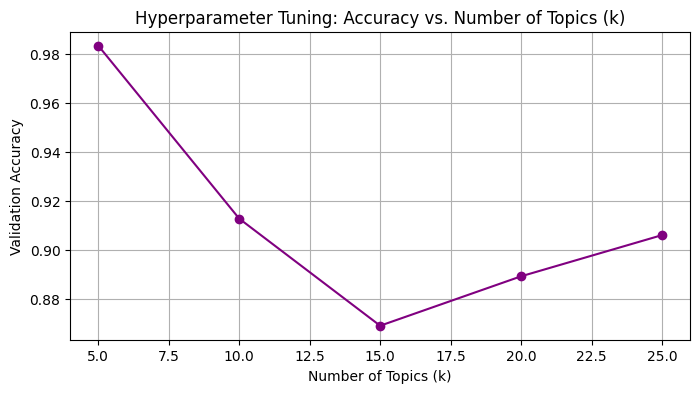

In [5]:
# plot and visualize
plt.figure(figsize=(8, 4))
plt.plot(results_df['k'], results_df['Validation Accuracy'], marker='o', linestyle='-', color='purple')
plt.title('Hyperparameter Tuning: Accuracy vs. Number of Topics (k)')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

## Train the Best Unsupervised Model

In [6]:
# use the best k found
k_best = 20 
nmf_model = NMF(
    n_components=k_best, random_state=RANDOM_STATE, max_iter=1000, 
    init='nndsvda', solver='mu', beta_loss='kullback-leibler'
)

W_train_full = nmf_model.fit_transform(X_train)
W_val_full = nmf_model.transform(X_val)

print("--- pre-trained best unsupervised model ---")

--- pre-trained best unsupervised model ---


# Unsupervised VS. Supervised

## Data Efficiency Comparison
- will vary the size of the training data (labels) used: 10%, 20%, 50%, 100%
- for Supervised, trains on the subset.
- for Unsupervised, uses subset labels to map the topics we already found.

In [7]:
train_sizes = [0.1, 0.2, 0.5, 1.0]
results_log = []

for frac in train_sizes:
    n_samples = int(X_train.shape[0] * frac)    
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]    
    W_subset = W_train_full[:n_samples]
    
    # model supervised
    clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    clf.fit(X_subset, y_subset)
    sup_preds = clf.predict(X_val)
    sup_acc = accuracy_score(y_val, sup_preds)
    
    # model unsupervised
    train_topics = np.argmax(W_subset, axis=1)
    cm = confusion_matrix(y_subset, train_topics)
    
    topic_mapping = np.zeros(k_best, dtype=int)
    
    present_topics = np.unique(train_topics)
    for t in present_topics:
        mask = (train_topics == t)
        labels_in_topic = y_subset[mask]
        if len(labels_in_topic) > 0:
            most_freq_label = np.bincount(labels_in_topic).argmax()
            topic_mapping[t] = most_freq_label

    # predict
    val_topics = np.argmax(W_val_full, axis=1)
    unsup_preds = topic_mapping[val_topics]
    unsup_acc = accuracy_score(y_val, unsup_preds)
    
    print(f"  Data Used: {int(frac*100)}% ({n_samples} docs) -> Sup Acc: {sup_acc:.4f} | Unsup Acc: {unsup_acc:.4f}")
    
    results_log.append({
        'Fraction': f"{int(frac*100)}%",
        'Supervised (LogReg)': sup_acc,
        'Unsupervised (NMF)': unsup_acc
    })

res_df = pd.DataFrame(results_log)
print("\n--- Comparison Summary Table ---")
print(res_df.to_markdown(index=False))

  Data Used: 10% (119 docs) -> Sup Acc: 0.7248 | Unsup Acc: 0.8624
  Data Used: 20% (238 docs) -> Sup Acc: 0.8758 | Unsup Acc: 0.8691
  Data Used: 50% (596 docs) -> Sup Acc: 0.9530 | Unsup Acc: 0.8826
  Data Used: 100% (1192 docs) -> Sup Acc: 0.9732 | Unsup Acc: 0.8893

--- Comparison Summary Table ---
| Fraction   |   Supervised (LogReg) |   Unsupervised (NMF) |
|:-----------|----------------------:|---------------------:|
| 10%        |              0.724832 |             0.862416 |
| 20%        |              0.875839 |             0.869128 |
| 50%        |              0.95302  |             0.88255  |
| 100%       |              0.973154 |             0.889262 |


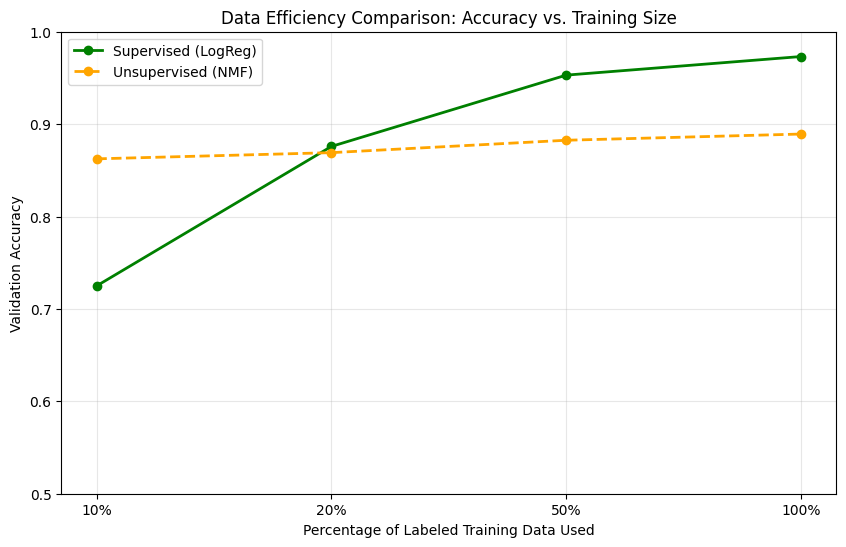

In [8]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(res_df['Fraction'], res_df['Supervised (LogReg)'], marker='o', label='Supervised (LogReg)', color='green', linewidth=2)
plt.plot(res_df['Fraction'], res_df['Unsupervised (NMF)'], marker='o', label='Unsupervised (NMF)', color='orange', linewidth=2, linestyle='--')

plt.title('Data Efficiency Comparison: Accuracy vs. Training Size')
plt.xlabel('Percentage of Labeled Training Data Used')
plt.ylabel('Validation Accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Accuracy

In [9]:
# train supervised (logistic regression) on the same X_train used for NMF
clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
clf.fit(X_train, y_train)

# predict on the same X_val
sup_preds = clf.predict(X_val)
sup_acc = accuracy_score(y_val, sup_preds)

print(f"--- Supervised Baseline Accuracy is: {sup_acc:.4f} ---")

--- Supervised Baseline Accuracy is: 0.9732 ---


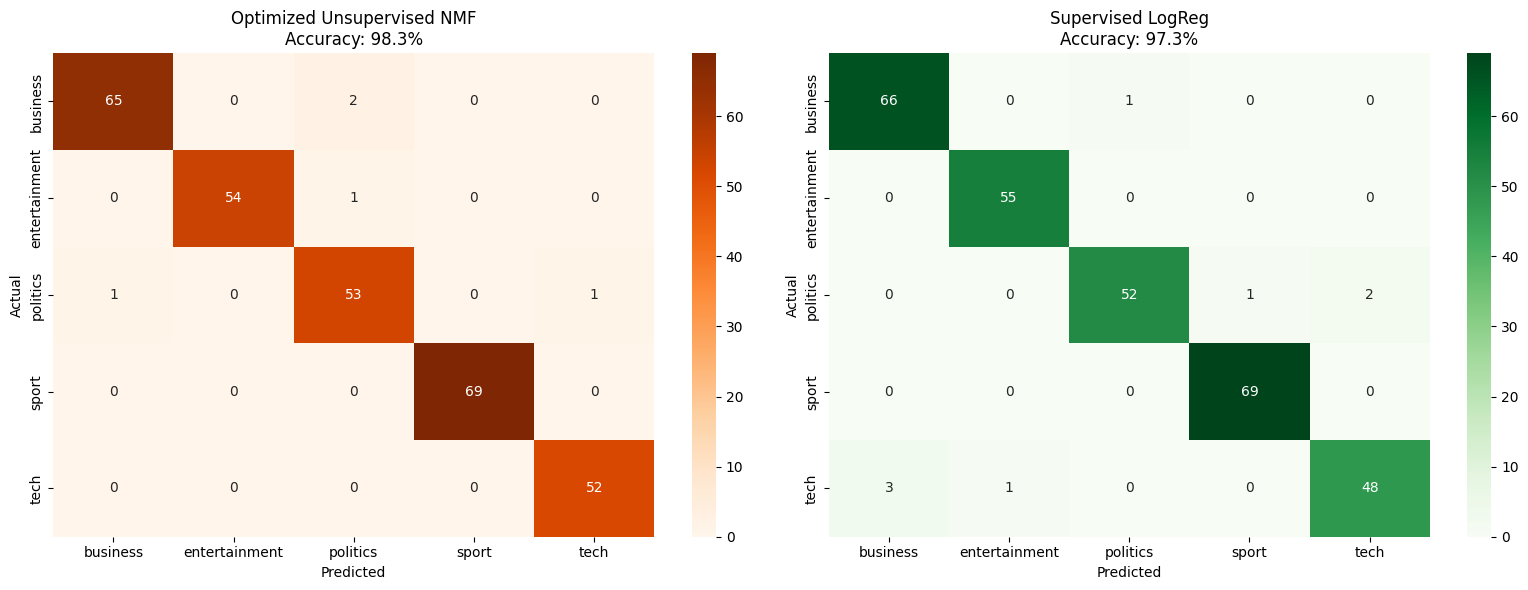

In [13]:
# plot and compare nmf vs logreg
le = LabelEncoder()
le.fit(train_df['Category'])
classes = le.classes_
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# plot unsupervised
cm_unsup = confusion_matrix(y_val, best_nmf_preds)
sns.heatmap(cm_unsup, annot=True, fmt='d', cmap='Oranges', ax=axes[0], 
            xticklabels=classes, yticklabels=classes)
axes[0].set_title(f'Optimized Unsupervised NMF\nAccuracy: {best_nmf_acc:.1%}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# plot supervised
cm_sup = confusion_matrix(y_val, sup_preds)
sns.heatmap(cm_sup, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            xticklabels=classes, yticklabels=classes)
axes[1].set_title(f'Supervised LogReg\nAccuracy: {sup_acc:.1%}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [14]:
comparison_df = pd.DataFrame({
    'Metric': ['Best Validation Accuracy', 'Approach', 'Input Data Requirements'],
    'Unsupervised (NMF)': [f"{best_nmf_acc:.4f}", 'Topic Discovery (KL-Divergence)', 'Raw Text Only'],
    'Supervised (LogReg)': [f"{sup_acc:.4f}", 'Class Boundary Optimization', 'Text + Labels']
})
print(comparison_df.to_markdown(index=False))

| Metric                   | Unsupervised (NMF)              | Supervised (LogReg)         |
|:-------------------------|:--------------------------------|:----------------------------|
| Best Validation Accuracy | 0.9832                          | 0.9732                      |
| Approach                 | Topic Discovery (KL-Divergence) | Class Boundary Optimization |
| Input Data Requirements  | Raw Text Only                   | Text + Labels               |
